In [1]:
## In this script we create the networks architecture and also train the networks.

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Classifier:

In [2]:
## Importing libraries

import tensorflow as tf
seed = 786
tf.keras.utils.set_random_seed(seed)
# tf.config.experimental.enable_op_determinism()

from tensorflow.keras import backend as K


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf
from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [3]:
## Function to normalize the traces in range [-1, 1]
def normalize_array(array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, scale_fac



## This class can change the learning rate with the given factor and patience
class LearningRateScheduler(Callback):
    def __init__(self, factor, patience):
        super(LearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait = 0
                print(f"Reducing learning rate to {new_lr}")

In [4]:
## Loading the data
## 

# ant = "ant1"
# DataDir = ("/mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Classifier/")

## Provide the data directory
DataDir = ""

x_train = np.load(DataDir + f"/TstTrn/{ant}_Traces_train.npy")
x_test = np.load(DataDir + f"/TstTrn/{ant}_Traces_test.npy")

y_train = np.load(DataDir + f"/TstTrn/{ant}_Labels_train.npy")
y_test = np.load(DataDir + f"/TstTrn/{ant}_Labels_test.npy")


### Normalizing
x_train, scalefac = normalize_array(x_train)
x_test, scalefacT = normalize_array(x_test)

In [9]:
x_train.shape

(267054, 1000, 2)

In [10]:
# x_train =  np.array(x_train, dtype='float32')
print(f"Total size in Gbs = {x_train.nbytes/10**9}")

Total size in Gbs = 4.272864


In [5]:
## Creating the Classifier network

def CreateModel(KS, FIL, Layers, lr=5e-3):

    # Define the input shape for each polarization
    input_shape = (1000, 2)  # 2 channels, 1 for each polarization

    # Define the input layer
    input_layer = Input(shape=input_shape)
    x = input_layer

    # Convolutional layers
    for i in range(Layers):
        x = Conv1D(filters=FIL, kernel_size=KS, activation='relu', padding='same')(x)
        x = MaxPooling1D(pool_size=2)(x)

    # Flatten the pooled output
    x = Flatten()(x)
    
    ## Adding more dense layers didn't help imporve results, but can be added like below
#     x = Dense(64, activation='relu')(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)

    # Compile the model, with defined loss and optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=['accuracy'])
    
    return model

In [8]:
ModelsDir = DataDir + "/TempModels"

### Training Settings
## Learning rate schefuler
lr_scheduler = LearningRateScheduler(factor=0.5, patience=5)

## Early Stopping Criterion
es = EarlyStopping(monitor='val_loss', mode='min',restore_best_weights=True, verbose=1, patience=5)

## Model checkpoints
mc = ModelCheckpoint(ModelsDir+f'/Classifier_{ant}.h5',
                                    monitor = 'val_loss', mode = 'min', verbose=1, save_best_only=True)

## Create networks
autoencoder = CreateModel(KS=33, FIL=6, Layers=3, lr=1e-4)

## Training (only doing for 10 epochs here)
history = autoencoder.fit(x_train, y_train,
                          epochs=10,
                          batch_size=500,
                          shuffle=True,
                          validation_data=(x_test, y_test),
                          callbacks=[lr_scheduler, es, mc])

Epoch 1/10
529/535 [============================>.] - ETA: 0s - loss: 0.2356 - accuracy: 0.5873
Epoch 00001: val_loss improved from inf to 0.22087, saving model to /mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Classifier//TempModels/Classifier_ant1.h5
535/535 [==============================] - 6s 9ms/step - loss: 0.2355 - accuracy: 0.5875 - val_loss: 0.2209 - val_accuracy: 0.6263
Epoch 2/10
527/535 [============================>.] - ETA: 0s - loss: 0.2199 - accuracy: 0.6269
Epoch 00002: val_loss improved from 0.22087 to 0.21856, saving model to /mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Classifier//TempModels/Classifier_ant1.h5
535/535 [==============================] - 3s 6ms/step - loss: 0.2199 - accuracy: 0.6270 - val_loss: 0.2186 - val_accuracy: 0.6295
Epoch 3/10
527/535 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.6298
Epoch 00003: val_loss improved from 0.21856 to 0.21757, saving model to /mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [10]:
train_loss = history.history[list(history.history.keys())[0]]
test_loss = history.history[list(history.history.keys())[2]]

train_accu = history.history[list(history.history.keys())[1]]
test_accu = history.history[list(history.history.keys())[3]]

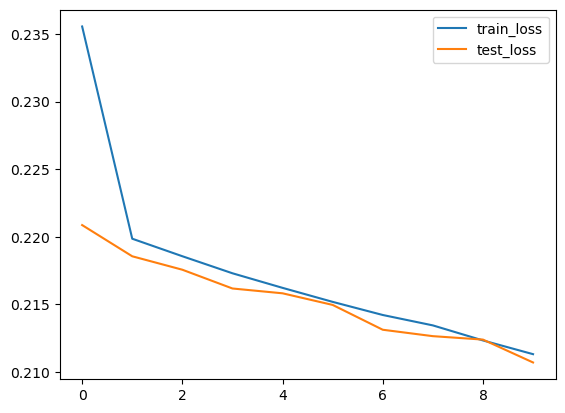

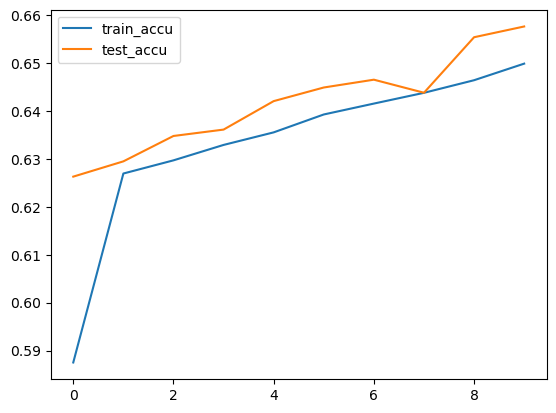

In [13]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()
plt.figure()
plt.plot(train_accu, label="train_accu")
plt.plot(test_accu, label="test_accu")
plt.legend();

# Denoiser

In [14]:
import tensorflow as tf
seed = 786
tf.keras.utils.set_random_seed(seed)
# tf.config.experimental.enable_op_determinism()

from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam, RMSprop


def normalize_deno_array(array, y_array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    normalized_y_array = np.zeros_like(array)  
    
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
            
            ## Normalizing labels
            normalized_y_sample = y_array[i] / max_value
            normalized_y_array[i] = normalized_y_sample
            
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, normalized_y_array, scale_fac


In [15]:
## Loading data

# ant = "ant1"
# DataDir = ("/mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Denoiser/TstTrn")

## Provide the denoiser data directory
DataDir = ""


x_train = np.load(DataDir + f"/{ant}_Noisy_train.npy")
x_test = np.load(DataDir + f"/{ant}_Noisy_test.npy")

y_train = np.load(DataDir + f"/{ant}_Signals_train.npy")
y_test = np.load(DataDir + f"/{ant}_Signals_test.npy")

### Normalizing
x_train, y_train, scalefac = normalize_deno_array(x_train, y_train)
x_test, y_test, scalefacT = normalize_deno_array(x_test, y_test)

In [16]:
class LearningRateScheduler(Callback):
    def __init__(self, factor, patience):
        super(LearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.wait = 0
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = float(K.get_value(self.model.optimizer.lr))
                new_lr = old_lr * self.factor
                K.set_value(self.model.optimizer.lr, new_lr)
                self.wait = 0
                print(f"Reducing learning rate to {new_lr}")

def CorrCoeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = mx
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    return r
# Custom correlation metric
def CC2(y_true, y_pred):
    def pearson_correlation(x, y):
        mean_x = K.mean(x)
        mean_y = K.mean(y)
        cov_xy = K.sum((x - mean_x) * (y - mean_y))
        std_x = K.sqrt(K.sum(K.square(x - mean_x)))
        std_y = K.sqrt(K.sum(K.square(y - mean_y)))
        correlation = cov_xy / (std_x * std_y)
        return correlation

    correlation = tf.py_function(pearson_correlation, [y_true, y_pred], tf.float32)
    return correlation


def Denoiser(fil, ks, lr=1e-3):
    input_shape = (1000, 2)

    # Encoder architecture
    input_layer = Input(shape=input_shape)
    
    x = Conv1D(fil, ks, activation='relu', padding='same')(input_layer)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)

    # Decoder architecture
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(fil, ks, activation='relu', padding='same')(x)
    x = UpSampling1D(2)(x)

    decoded = Conv1D(2, ks, activation='linear', padding='same')(x)

    # Create the autoencoder model
    autoencoder = Model(input_layer, decoded)

    # Compile the model
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse', metrics=[CorrCoeff])
    
    return autoencoder

In [17]:
ModelsDir = DataDir + "/TestModels"

### Training
lr_scheduler = LearningRateScheduler(factor=0.5, patience=5)
es = EarlyStopping(monitor='val_loss', mode='min',restore_best_weights=True, verbose=1, patience=5)
mc = ModelCheckpoint(ModelsDir+f'/Denoiser_{ant}.h5',
                                    monitor = 'val_loss', mode = 'min', verbose=1, save_best_only=True)

autoencoder = Denoiser(fil=12, ks=33, lr=1e-4)

history = autoencoder.fit(x_train, y_train, 
                          epochs=10, 
                          batch_size=200, 
                          shuffle=True,
                          validation_data=(x_test, y_test), 
                          callbacks=[lr_scheduler, es, mc])

Epoch 1/10
668/668 [==============================] - ETA: 0s - loss: 0.0015 - CorrCoeff: 0.2632
Epoch 00001: val_loss improved from inf to 0.00076, saving model to /mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Denoiser/TstTrn/TestModels/Denoiser_ant1.h5
668/668 [==============================] - 17s 20ms/step - loss: 0.0015 - CorrCoeff: 0.2632 - val_loss: 7.6105e-04 - val_CorrCoeff: 0.7446
Epoch 2/10
667/668 [============================>.] - ETA: 0s - loss: 5.7242e-04 - CorrCoeff: 0.8158
Epoch 00002: val_loss improved from 0.00076 to 0.00046, saving model to /mnt/janus/arehman/work/2024_V7/JanFeb_70-350/2D_CNN/Denoiser/TstTrn/TestModels/Denoiser_ant1.h5
668/668 [==============================] - 12s 18ms/step - loss: 5.7235e-04 - CorrCoeff: 0.8159 - val_loss: 4.6243e-04 - val_CorrCoeff: 0.8538
Epoch 3/10
665/668 [============================>.] - ETA: 0s - loss: 4.1360e-04 - CorrCoeff: 0.8710
Epoch 00003: val_loss improved from 0.00046 to 0.00037, saving model to /mnt/janus/ar

In [18]:
history.history.keys()

dict_keys(['loss', 'CorrCoeff', 'val_loss', 'val_CorrCoeff'])

In [19]:
history.history.keys()
train_loss = history.history[list(history.history.keys())[0]]
test_loss = history.history[list(history.history.keys())[2]]

train_accu = history.history[list(history.history.keys())[1]]
test_accu = history.history[list(history.history.keys())[3]]

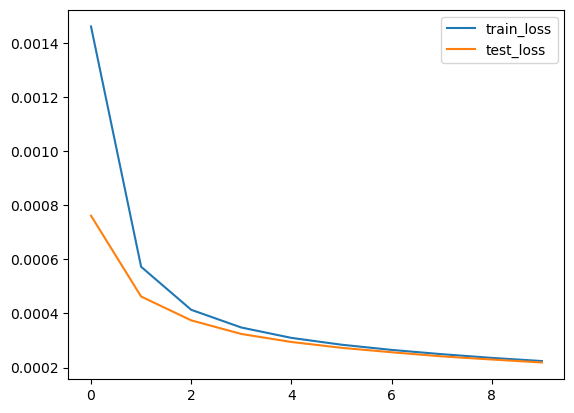

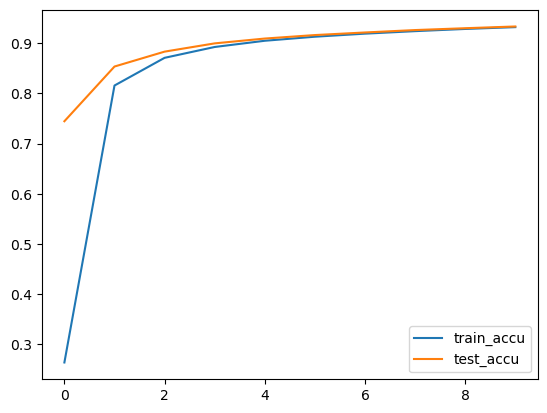

In [20]:
plt.plot(train_loss, label="train_loss")
plt.plot(test_loss, label="test_loss")
plt.legend()
plt.figure()
plt.plot(train_accu, label="train_accu")
plt.plot(test_accu, label="test_accu")
plt.legend();